In [116]:
import os
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random,math
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [117]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f1 = pd.read_csv('../input/f1_train.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]
# test_f1 = pd.read_csv('../input/f1_test.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]



sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 45.2 s, sys: 3.71 s, total: 49 s
Wall time: 48.7 s


In [118]:
# train_f5 = pd.read_csv('../input/f5_train2.csv', index_col='TransactionID').iloc[:,:3]
# test_f5 = pd.read_csv('../input/f5_test2.csv', index_col='TransactionID').iloc[:,:3]
train_f6 = pd.read_csv('../input/f5_train3.csv', index_col='TransactionID').iloc[:,:3]
test_f6 = pd.read_csv('../input/f5_test3.csv', index_col='TransactionID').iloc[:,:3]

In [119]:
import pickle
f = open('mail_columns_ProNE_32.pickle','rb')
f_prone = pickle.loads(f.read()) 
f.close()
del f_prone['TransactionID']
print(f_prone.shape)

f_prone_train = f_prone.iloc[:train_transaction.shape[0]]
f_prone_train.index = train_transaction.index
f_prone_test = f_prone.iloc[train_transaction.shape[0]:]
f_prone_test.index = test_transaction.index
f_prone_col = f_prone.columns
print(f_prone.columns)

(1097231, 32)
Index(['mail_columns_ProNE_Emb_0', 'mail_columns_ProNE_Emb_1',
       'mail_columns_ProNE_Emb_2', 'mail_columns_ProNE_Emb_3',
       'mail_columns_ProNE_Emb_4', 'mail_columns_ProNE_Emb_5',
       'mail_columns_ProNE_Emb_6', 'mail_columns_ProNE_Emb_7',
       'mail_columns_ProNE_Emb_8', 'mail_columns_ProNE_Emb_9',
       'mail_columns_ProNE_Emb_10', 'mail_columns_ProNE_Emb_11',
       'mail_columns_ProNE_Emb_12', 'mail_columns_ProNE_Emb_13',
       'mail_columns_ProNE_Emb_14', 'mail_columns_ProNE_Emb_15',
       'mail_columns_ProNE_Emb_16', 'mail_columns_ProNE_Emb_17',
       'mail_columns_ProNE_Emb_18', 'mail_columns_ProNE_Emb_19',
       'mail_columns_ProNE_Emb_20', 'mail_columns_ProNE_Emb_21',
       'mail_columns_ProNE_Emb_22', 'mail_columns_ProNE_Emb_23',
       'mail_columns_ProNE_Emb_24', 'mail_columns_ProNE_Emb_25',
       'mail_columns_ProNE_Emb_26', 'mail_columns_ProNE_Emb_27',
       'mail_columns_ProNE_Emb_28', 'mail_columns_ProNE_Emb_29',
       'mail_columns_

In [120]:
train_transaction['TransactionDT2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))
test_transaction['TransactionDT2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))

f = open('emb/index_feature.pkl','rb')
index_feature = pickle.loads(f.read())
feature_index = {}
for k,v in index_feature.items():
    feature_index[v] = k
    print(k,v)

embeddings_matrix = np.load("emb/spectral.emb.npy")
print(embeddings_matrix.shape)
embeddings_dict = {}
for i in range((embeddings_matrix.shape[0])):
    embeddings_dict[feature_index[i]] = embeddings_matrix[i,:]

for col in "P_emaildomain".split(","):
    print(col)
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])       
        #         print(train_transaction["w2v_"+col+str(i)])         

for col in "card1,card2,addr1".split(","):
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])

# for col in "TransactionDT".split(","):
#     print(col)
#     for i in range(24):
#         train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].map(lambda x:(x)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT"+"_"+str(int(x)),[0]*24)[i])
#         test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].map(lambda x:(x)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT"+"_"+str(int(x)),[0]*24)[i])
#         train_transaction["w2v_"+col+"2_"+str(i)] = train_transaction[col].map(lambda x:(x+3600*24*3.5)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT2"+"_"+str(int(x)),[0]*24)[i])
#         test_transaction["w2v_"+col+"2_"+str(i)] = test_transaction[col].map(lambda x:(x+3600*24*3.5)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT2"+"_"+str(int(x)),[0]*24)[i])


TransactionDT_0 0
TransactionDT2_0 1
card1_13926 2
addr1_315 3
card2_-1 4
P_emaildomain_-1 5
card1_2755 6
addr1_325 7
card2_404 8
P_emaildomain_gmail.com 9
card1_4663 10
addr1_330 11
card2_490 12
P_emaildomain_outlook.com 13
card1_18132 14
addr1_476 15
card2_567 16
P_emaildomain_yahoo.com 17
card1_4497 18
addr1_420 19
card2_514 20
card1_5937 21
addr1_272 22
card2_555 23
card1_12308 24
addr1_126 25
card2_360 26
card1_12695 27
P_emaildomain_mail.com 28
card1_2803 29
addr1_337 30
card2_100 31
P_emaildomain_anonymous.com 32
card1_17399 33
addr1_204 34
card2_111 35
card1_16496 36
addr1_-1 37
card2_352 38
card1_4461 39
card2_375 40
P_emaildomain_hotmail.com 41
card1_3786 42
card2_418 43
P_emaildomain_verizon.net 44
card1_12866 45
card2_303 46
P_emaildomain_aol.com 47
card1_11839 48
addr1_226 49
card1_7055 50
card1_1790 51
addr1_170 52
card1_11492 53
addr1_184 54
card1_7005 55
addr1_264 56
card1_7875 57
addr1_299 58
card2_314 59
card1_11401 60
card2_543 61
card1_1724 62
card2_583 63
card1_239

card1_6862 998
card1_10004 999
card1_12620 1000
card1_13719 1001
card1_14665 1002
card1_8606 1003
card1_2790 1004
card1_9257 1005
card1_15687 1006
card1_15597 1007
card1_12590 1008
card1_17820 1009
card1_5492 1010
card2_113 1011
card1_6892 1012
card2_560 1013
card1_16081 1014
card1_7323 1015
card1_1976 1016
card1_16883 1017
card1_1870 1018
card1_3056 1019
card1_17910 1020
card1_2302 1021
card1_11366 1022
card1_15930 1023
card1_15678 1024
card1_7025 1025
card2_389 1026
card1_8765 1027
card1_12592 1028
card1_14102 1029
card1_12442 1030
card1_9206 1031
card1_9790 1032
card1_17933 1033
card1_2039 1034
card1_16115 1035
card2_431 1036
card1_11966 1037
card1_8522 1038
card1_11533 1039
card1_17416 1040
card1_7669 1041
card1_13290 1042
card1_18334 1043
card2_589 1044
card1_5909 1045
card1_6554 1046
card2_592 1047
card1_10967 1048
card1_1663 1049
card1_15107 1050
card1_2601 1051
card2_336 1052
card1_6489 1053
card2_295 1054
card1_12583 1055
card1_7493 1056
card2_515 1057
card1_8190 1058
card1_12

card1_4456 2214
card1_4225 2215
card1_2833 2216
card1_11902 2217
card1_9231 2218
card1_7790 2219
card1_18342 2220
card1_8423 2221
card1_3851 2222
card1_14249 2223
card1_14332 2224
card1_13674 2225
card1_4238 2226
card2_153 2227
card1_10706 2228
card1_16807 2229
card1_12065 2230
card2_575 2231
card1_5219 2232
card1_3029 2233
card1_6856 2234
card1_15128 2235
card2_190 2236
card1_10582 2237
card1_14610 2238
card2_495 2239
card1_1387 2240
card1_7148 2241
card1_9856 2242
card1_11148 2243
card1_2764 2244
card1_12996 2245
card1_6751 2246
card2_289 2247
card1_15397 2248
card2_465 2249
card1_14070 2250
card1_14012 2251
card1_3383 2252
card1_6288 2253
card1_17466 2254
card1_17669 2255
card2_541 2256
card1_12846 2257
card1_13600 2258
card1_10719 2259
card1_11892 2260
card1_4251 2261
card1_3520 2262
card1_3171 2263
card1_5376 2264
card1_12321 2265
card1_10371 2266
card1_7632 2267
card1_2125 2268
card2_362 2269
card1_8949 2270
card1_4908 2271
card1_3724 2272
card1_17452 2273
card1_3602 2274
card2_1

card1_3697 3554
card1_10726 3555
card1_11078 3556
card1_4531 3557
card1_15516 3558
card1_16274 3559
card2_331 3560
card1_16473 3561
card1_10038 3562
card1_8321 3563
addr1_218 3564
card1_13680 3565
card1_10106 3566
card1_11981 3567
card1_11693 3568
card1_7349 3569
card1_1929 3570
card1_5950 3571
card1_1079 3572
card1_13432 3573
card1_13155 3574
card2_329 3575
card1_2373 3576
card1_2049 3577
addr1_127 3578
card1_13341 3579
card1_14089 3580
card1_6619 3581
card1_10503 3582
card1_5354 3583
card1_5758 3584
card1_2251 3585
card1_14326 3586
card1_1954 3587
card1_14743 3588
card1_17001 3589
card1_14926 3590
card1_7997 3591
card1_10631 3592
addr1_403 3593
card1_11140 3594
card1_17398 3595
card1_12364 3596
card2_483 3597
card1_9613 3598
card1_10358 3599
card1_15106 3600
card1_2841 3601
card1_2632 3602
card1_11574 3603
card1_1778 3604
card1_13814 3605
card1_15236 3606
card1_12459 3607
card1_18106 3608
card1_9091 3609
card1_4778 3610
card1_6448 3611
card1_9447 3612
card1_7503 3613
card1_2074 3614


card1_13621 4804
card1_9571 4805
card1_11742 4806
card1_5885 4807
card1_13260 4808
card1_12569 4809
card1_7684 4810
card1_11116 4811
card1_6922 4812
card1_10916 4813
card1_11239 4814
card1_2816 4815
card1_10179 4816
card1_4860 4817
card1_8628 4818
card1_17999 4819
card2_482 4820
card1_10350 4821
card1_17027 4822
card1_5819 4823
card1_10177 4824
addr1_213 4825
card1_2587 4826
card1_8599 4827
card1_9853 4828
card1_8082 4829
addr1_514 4830
card1_5641 4831
card1_4642 4832
card1_8776 4833
card1_11793 4834
card1_12587 4835
card1_3366 4836
card1_1837 4837
card1_9099 4838
card1_5427 4839
card1_13200 4840
card1_6281 4841
card1_6910 4842
card1_17825 4843
card1_6068 4844
card1_14306 4845
card1_4231 4846
card1_5424 4847
card1_14408 4848
card1_16248 4849
card1_2278 4850
card1_8500 4851
card1_3636 4852
card1_10054 4853
card1_9069 4854
card1_3028 4855
card1_17348 4856
card1_1592 4857
card1_2202 4858
card1_15411 4859
card1_5401 4860
card1_9838 4861
card1_14212 4862
card1_8195 4863
card1_5815 4864
card

card1_2483 6054
card1_15376 6055
card1_5681 6056
card1_15949 6057
card1_16142 6058
card1_7219 6059
card1_5435 6060
card1_13054 6061
card1_17891 6062
card1_6398 6063
card1_4590 6064
card1_15647 6065
card1_1704 6066
card1_1027 6067
addr1_360 6068
card1_6042 6069
card1_15035 6070
addr1_516 6071
card1_8854 6072
card1_12205 6073
card1_5336 6074
card1_8809 6075
card1_14107 6076
card1_18042 6077
card1_12008 6078
card1_16459 6079
addr1_353 6080
card1_16968 6081
card1_8898 6082
card1_12644 6083
card1_2226 6084
card1_13114 6085
card1_4738 6086
card1_14776 6087
card1_17625 6088
card1_1057 6089
card1_5320 6090
card1_2837 6091
card1_13543 6092
card1_10818 6093
card1_7123 6094
addr1_101 6095
card1_18062 6096
card1_9710 6097
addr1_513 6098
card1_11626 6099
card1_8141 6100
card1_1863 6101
card1_12233 6102
card1_8169 6103
card1_3972 6104
card1_13885 6105
card1_9118 6106
card1_4716 6107
card1_10034 6108
card1_9673 6109
card1_8964 6110
card1_3093 6111
card1_5817 6112
card1_16745 6113
card1_8461 6114
card

card1_14006 7141
card1_13696 7142
card1_6426 7143
card1_2158 7144
card1_16105 7145
card1_13664 7146
card1_6038 7147
card1_3385 7148
card1_14075 7149
card1_14370 7150
card1_5231 7151
card1_18271 7152
card1_12481 7153
card1_7485 7154
card1_16880 7155
card1_5045 7156
card1_14223 7157
card1_11393 7158
card1_11940 7159
card1_3668 7160
card1_16461 7161
card1_3257 7162
card1_2381 7163
card1_1812 7164
card1_16722 7165
card1_12714 7166
card1_14397 7167
card1_10153 7168
card1_8440 7169
card1_3515 7170
card1_5802 7171
card1_5364 7172
card1_12950 7173
card1_11354 7174
card1_8966 7175
card1_3907 7176
card1_3635 7177
card1_13409 7178
card1_14983 7179
card1_7782 7180
card1_2879 7181
card1_6106 7182
card1_12682 7183
card1_16786 7184
card1_6914 7185
card1_5864 7186
card1_7471 7187
card1_14177 7188
card1_1603 7189
card1_1429 7190
card1_7798 7191
card1_9835 7192
card1_5194 7193
card1_7434 7194
card1_7750 7195
card1_5553 7196
card1_4343 7197
card1_13492 7198
card1_6543 7199
card1_7048 7200
card1_2853 7201

card1_11957 8303
card1_9139 8304
card1_7012 8305
card1_3494 8306
card1_16654 8307
card1_13672 8308
card1_14845 8309
card1_1516 8310
card1_7330 8311
card1_13227 8312
card1_1646 8313
card1_18174 8314
card1_4401 8315
card1_6103 8316
card1_4940 8317
card1_4101 8318
card1_10095 8319
card1_7196 8320
card1_12440 8321
card1_1435 8322
card1_10855 8323
card1_6214 8324
card1_5003 8325
card1_2417 8326
card1_4520 8327
card1_15785 8328
card1_7119 8329
card1_3551 8330
card1_4435 8331
card1_8901 8332
card1_10410 8333
card1_9644 8334
card1_7809 8335
card1_15718 8336
card1_6129 8337
card1_8430 8338
card1_4709 8339
card1_1235 8340
card1_6799 8341
card1_2999 8342
card1_14611 8343
card1_6171 8344
card1_4588 8345
card1_3233 8346
card1_14870 8347
card1_12868 8348
card1_4410 8349
card1_2885 8350
card1_3761 8351
card1_7400 8352
card1_12306 8353
card1_14517 8354
card1_18229 8355
card1_4875 8356
card1_6524 8357
card1_9573 8358
card1_4177 8359
card1_10296 8360
card1_5543 8361
card1_8030 8362
card1_18242 8363
card

card1_10883 9553
card1_11791 9554
card1_7281 9555
card1_2555 9556
card1_8993 9557
card1_11897 9558
card1_1292 9559
card1_9378 9560
card1_4024 9561
card1_5991 9562
card1_2591 9563
card1_2131 9564
card1_9051 9565
card1_9057 9566
card1_18318 9567
card1_13907 9568
card1_4038 9569
card1_8866 9570
card1_9250 9571
card1_13563 9572
card1_17432 9573
card1_16408 9574
card1_9878 9575
card1_3384 9576
card1_9095 9577
card1_17356 9578
card1_10131 9579
card1_16045 9580
card1_7018 9581
card1_10557 9582
card1_11639 9583
card1_13880 9584
card1_17455 9585
card1_15896 9586
card1_13976 9587
card1_12976 9588
card1_8799 9589
card1_10805 9590
card1_15951 9591
card1_5705 9592
card1_12166 9593
card1_16300 9594
card1_4621 9595
card1_17205 9596
card1_17773 9597
card1_16500 9598
card1_7264 9599
card1_16867 9600
card1_16043 9601
card1_18047 9602
card1_5668 9603
card1_15786 9604
card1_12917 9605
card1_2861 9606
card1_17821 9607
card1_11719 9608
card1_16457 9609
card1_16319 9610
card1_13109 9611
card1_2507 9612
card1

card1_7441 10705
card1_14513 10706
card1_5349 10707
card1_11654 10708
card1_1255 10709
card1_14866 10710
card1_6002 10711
card1_16480 10712
card1_10931 10713
card1_14522 10714
card1_3557 10715
card1_17532 10716
card1_3768 10717
card1_14002 10718
card1_7133 10719
card1_1084 10720
card1_1851 10721
card1_16110 10722
card1_11090 10723
card1_14594 10724
card1_8658 10725
card1_16273 10726
card1_16850 10727
card1_14300 10728
card1_1195 10729
card1_10308 10730
card1_8275 10731
card1_1792 10732
card1_5084 10733
card1_10073 10734
card1_8143 10735
card1_7693 10736
card1_5232 10737
card1_9686 10738
card1_11676 10739
card1_5235 10740
card1_13238 10741
card1_18237 10742
card1_13332 10743
card1_17199 10744
card1_18363 10745
card1_16422 10746
card1_1336 10747
card1_5467 10748
card1_6817 10749
card1_15089 10750
card1_1864 10751
card1_3753 10752
card1_12948 10753
addr1_276 10754
card1_1689 10755
card1_17213 10756
card1_6678 10757
card1_9247 10758
card1_3329 10759
card1_7645 10760
card1_12499 10761
card1

card1_13483 12066
card1_7346 12067
card1_5418 12068
card1_14330 12069
card1_1271 12070
card1_17474 12071
card1_5391 12072
card1_10546 12073
card1_6010 12074
card1_8656 12075
card1_3866 12076
card1_8254 12077
card1_13493 12078
card1_13529 12079
card1_4008 12080
card1_2818 12081
card1_10367 12082
card1_8308 12083
card1_4110 12084
card1_17258 12085
card1_17166 12086
card1_2476 12087
card1_9143 12088
card1_15088 12089
card1_10832 12090
card1_1304 12091
card1_5485 12092
card1_4635 12093
card1_7980 12094
card1_17744 12095
card1_13905 12096
TransactionDT2_13 12097
card1_10831 12098
card1_13343 12099
card1_4166 12100
card1_16559 12101
card1_1268 12102
card1_6538 12103
card1_16213 12104
card1_3743 12105
card1_3192 12106
card1_4103 12107
card1_1427 12108
card1_9771 12109
card1_2854 12110
card1_5103 12111
card1_16989 12112
card1_13081 12113
card1_3293 12114
card1_3467 12115
card1_8336 12116
card1_14413 12117
card1_4939 12118
card1_2932 12119
card1_15605 12120
card1_7498 12121
card1_5470 12122
car

card1_10826 13412
card1_3894 13413
card1_16212 13414
card1_3061 13415
card1_11798 13416
card1_12292 13417
card1_8344 13418
card1_14029 13419
card1_12742 13420
card1_7189 13421
card1_6876 13422
card1_3151 13423
card1_14352 13424
card1_14701 13425
card1_11767 13426
card1_12162 13427
card1_2514 13428
card1_8297 13429
card1_11803 13430
card1_5020 13431
card1_9184 13432
card1_14957 13433
card1_7992 13434
card1_17627 13435
card1_8228 13436
card1_16553 13437
card1_3619 13438
card1_11340 13439
card1_11439 13440
card1_17815 13441
card1_12984 13442
card1_8889 13443
card1_8237 13444
card1_1981 13445
card1_2737 13446
card1_18241 13447
card1_16134 13448
card1_13063 13449
card1_9256 13450
card1_15550 13451
card1_12328 13452
card1_11394 13453
card1_14360 13454
card1_7783 13455
card1_2788 13456
card1_18323 13457
card1_8342 13458
card1_15414 13459
card1_12333 13460
card1_12814 13461
card1_15054 13462
card1_16598 13463
card1_8326 13464
card1_10897 13465
card1_17655 13466
card1_6446 13467
card1_10660 134

card1_12585 14476
card1_5799 14477
card1_10991 14478
card1_11353 14479
card1_3018 14480
card1_9147 14481
card1_5654 14482
card1_1099 14483
card1_3128 14484
card1_4163 14485
card1_3776 14486
card1_8544 14487
card1_7060 14488
TransactionDT_26 14489
card1_1571 14490
card1_2636 14491
card1_11854 14492
card1_13753 14493
card1_1041 14494
card1_11016 14495
card1_7236 14496
card1_17972 14497
card1_13166 14498
card1_8767 14499
card1_18038 14500
TransactionDT_30 14501
TransactionDT2_30 14502
card1_14991 14503
card1_4807 14504
card1_8579 14505
card1_17212 14506
TransactionDT2_31 14507
card1_16176 14508
card1_5240 14509
card1_3505 14510
card1_6988 14511
card1_12193 14512
card1_15037 14513
card1_7513 14514
card1_5074 14515
card1_15259 14516
card1_7665 14517
card1_11210 14518
card1_17236 14519
card1_3713 14520
card1_3268 14521
card1_8262 14522
card1_11909 14523
card1_16318 14524
card1_10969 14525
card1_1653 14526
card1_11216 14527
card1_4862 14528
card1_4561 14529
card1_9466 14530
card1_6686 14531
c

card1_15555 15934
card1_15190 15935
TransactionDT2_41 15936
card1_2452 15937
card1_2707 15938
card1_12387 15939
card1_14779 15940
card1_2073 15941
card1_4712 15942
card1_11067 15943
card1_13914 15944
card1_4384 15945
card1_10030 15946
card1_1930 15947
card1_14945 15948
card1_2924 15949
card1_5049 15950
card1_16301 15951
card1_9360 15952
card1_7275 15953
card1_7953 15954
card1_14411 15955
card1_3245 15956
card1_14717 15957
card1_14144 15958
card1_2988 15959
card1_12703 15960
card1_6956 15961
card1_7991 15962
card1_4498 15963
card1_6562 15964
card1_11567 15965
card1_17397 15966
card1_15979 15967
card1_3794 15968
card1_2975 15969
card1_2446 15970
card1_10917 15971
card1_11737 15972
card1_6772 15973
card1_17623 15974
card1_5083 15975
card1_11510 15976
card1_18206 15977
card1_14071 15978
card1_2673 15979
card1_7351 15980
card1_1718 15981
card1_9193 15982
card1_8105 15983
card1_9768 15984
card1_14978 15985
card1_14946 15986
card1_12142 15987
card1_11185 15988
card1_5946 15989
card1_14435 159

card1_12658 17288
card1_16739 17289
card1_13958 17290
card1_1817 17291
card1_2385 17292
card1_7656 17293
card1_7724 17294
card1_12964 17295
card1_11380 17296
card1_13986 17297
card1_4259 17298
card1_14457 17299
card1_13224 17300
card1_14534 17301
card1_12371 17302
card1_2374 17303
TransactionDT_52 17304
card1_5748 17305
card1_11545 17306
card1_13177 17307
card1_7106 17308
card1_17543 17309
addr1_344 17310
card1_4549 17311
card1_5029 17312
card1_18022 17313
card1_3297 17314
card1_3161 17315
card1_16031 17316
card1_1203 17317
card1_13532 17318
card1_1166 17319
card1_17424 17320
card1_9094 17321
card1_13083 17322
card1_16299 17323
card1_17272 17324
card1_10651 17325
card1_16433 17326
card1_14918 17327
card1_1670 17328
card1_9418 17329
card1_5184 17330
card1_15470 17331
card1_1319 17332
card1_11404 17333
card1_5722 17334
card1_1456 17335
card1_17590 17336
card1_17992 17337
card1_8479 17338
card1_12743 17339
card1_12651 17340
card1_3359 17341
card1_12053 17342
card1_13132 17343
card1_14113 

In [121]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
# train_transaction['hour2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
# test_transaction['hour2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24)))
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
train_transaction['TransactionAmt_decimal'] = ((train_transaction['TransactionAmt'] - train_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)
test_transaction['TransactionAmt_decimal'] = ((test_transaction['TransactionAmt'] - test_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)

In [122]:
from collections import Counter
from math import log2,log10
def entropy(pr):
    total = len(pr)
    pr = Counter(pr)
    log2 = math.log2
    ent = 0
    for i in pr:
        p = float(pr[i]) / total
        ent += (-p) * log2(p)
    return ent

In [123]:
train_test = train_transaction.append(test_transaction)
for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
    train_transaction["_".join(col)] = train_transaction[col[0]].fillna(-1).map(str) + "_" + train_transaction[col[1]].fillna(-1).map(str)
    test_transaction["_".join(col)] = test_transaction[col[0]].fillna(-1).map(str) + "_" + test_transaction[col[1]].fillna(-1).map(str)
    
train_test = train_transaction.append(test_transaction)
# for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
#     col_count = train_test.groupby("_".join(col))['TransactionDT'].count()
#     train_transaction["_".join(col)+'_count'] = train_transaction["_".join(col)].map(col_count)
#     test_transaction["_".join(col)+'_count'] = test_transaction["_".join(col)].map(col_count)
#     del train_transaction["_".join(col)],test_transaction["_".join(col)]


for col in ["card1","card1_card2","card2_addr1"]:
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)

for col in [["card2","addr1"],["card1","card2"],["card1","addr1"]]:
    col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
    train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
    test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count)  
    del train_transaction["_".join(col)],test_transaction["_".join(col)]
    
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    
    
for col in [["card1",["addr1","card2","P_emaildomain"]],["card2",["addr1","P_emaildomain"]]]:
    for col2 in col[1]:
        train_transaction['next'+col[0]+col2] = train_transaction.groupby(col[0])[col2].shift(-1)
        train_transaction['next'+col[0]+col2] = (train_transaction['next'+col[0]+col2] == train_transaction[col2]).astype(int)
        test_transaction['next'+col[0]+col2] = test_transaction.groupby(col[0])[col2].shift(-1)
        test_transaction['next'+col[0]+col2] = (test_transaction['next'+col[0]+col2] == test_transaction[col2]).astype(int)            
#     s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())

# for col in "card1,card2,card3,card5,addr1,addr2".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     for i in range(bin):
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

# train_transaction["addr2"] = train_transaction["addr1"].map(str) + "_" + train_transaction["addr2"].map(str)
# test_transaction["addr2"] = test_transaction["addr1"].map(str) + "_" + test_transaction["addr2"].map(str)
    
#     col_count = train_test.groupby(col)['TransactionDT'].count().fillna(0)
#     col_count = col_count.reset_index()
#     col_count.columns = col + ["_".join(col)+'_count']
#     index = train_transaction.index
#     train_transaction = train_transaction.merge(col_count, how='left', on = col)
#     train_transaction.index = index
#     index = test_transaction.index
#     test_transaction = test_transaction.merge(col_count, how='left', on = col)
#     test_transaction.index = index


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)
    
    for col2 in "C5,C8".split(','):
        col_count1 = train_test[train_test[col2] == 0].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 0].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    for col2 in "C13".split(','):
        col_count1 = train_test[train_test[col2] == 1].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 1].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

train_transaction['TransactionAmt_to_mean_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_mean_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_std_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
train_transaction['TransactionAmt_to_std_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_mean_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_mean_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_std_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_std_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('std')

# train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
# train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
# train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

# test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
# test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
# test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
# test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train_transaction['D15_to_mean_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('mean')
train_transaction['D15_to_mean_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('mean')
train_transaction['D15_to_std_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('std')
train_transaction['D15_to_std_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('std')

test_transaction['D15_to_mean_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('mean')
test_transaction['D15_to_mean_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('mean')
test_transaction['D15_to_std_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('std')
test_transaction['D15_to_std_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('std')

train_transaction['D15_to_mean_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('mean')
train_transaction['D15_to_std_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('std')

test_transaction['D15_to_mean_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('mean')
test_transaction['D15_to_std_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('std')

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [124]:
for col in "C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
#     print(col,train_test[col].value_counts())
    col_count = train_test.fillna(-1).groupby(col)['TransactionDT'].count()
    print(col_count)
    minnum = col_count[col_count == 1].index.min()
    print((col_count <= 2).sum(),col_count[col_count <= 2].index.max(),col_count[col_count <= 2].index.min(),col_count[col_count == 1].index.min())
#     train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
#     test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
    train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
    test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)

C1
-1.0            3
 0.0         5291
 1.0       586742
 2.0       197520
 3.0        96569
 4.0        53794
 5.0        32851
 6.0        19774
 7.0        12984
 8.0         9068
 9.0         6383
 10.0        4873
 11.0        3736
 12.0        3187
 13.0        2399
 14.0        1921
 15.0        1515
 16.0        1356
 17.0        1293
 18.0        1120
 19.0         894
 20.0         868
 21.0         712
 22.0         717
 23.0         492
 24.0         563
 25.0         525
 26.0         401
 27.0         431
 28.0         415
            ...  
 4629.0         1
 4630.0         1
 4631.0         1
 4632.0         1
 4633.0         1
 4635.0         1
 4642.0         1
 4643.0         1
 4644.0         1
 4645.0         3
 4651.0         1
 4653.0         1
 4654.0         1
 4655.0         1
 4658.0         2
 4660.0         4
 4661.0         2
 4662.0         1
 4663.0         3
 4665.0         1
 4666.0         1
 4667.0         2
 4668.0         1
 4669.0         1
 4670.0

C9
-1.0           3
 0.0      341561
 1.0      420354
 2.0      146643
 3.0       64015
 4.0       31672
 5.0       16483
 6.0       10670
 7.0        6499
 8.0        4712
 9.0        3351
 10.0       2128
 11.0       1871
 12.0       1395
 13.0       1123
 14.0        938
 15.0        786
 16.0        597
 17.0        522
 18.0        460
 19.0        524
 20.0        366
 21.0        369
 22.0        340
 23.0        251
 24.0        269
 25.0        200
 26.0        205
 27.0        182
 28.0        230
           ...  
 528.0         4
 535.0         2
 537.0         1
 539.0         1
 540.0         7
 543.0         2
 544.0         2
 545.0         1
 549.0         1
 550.0         2
 551.0         1
 553.0         1
 554.0         4
 555.0         2
 557.0         1
 558.0        10
 559.0         3
 560.0         2
 561.0         1
 562.0         1
 563.0         1
 564.0         6
 565.0         3
 566.0         9
 567.0         9
 568.0         1
 569.0         1
 570.0     

In [125]:
# train_test['card1'] = train_test['card1'].fillna(-999)
# colcount = train_test.groupby('card1')['TransactionAmt'].mean().sort_values()
# colcount[:] = np.array(range(colcount.shape[0]))
# train_transaction['card7'] = train_transaction['card1'].fillna(-999).map(colcount)
# test_transaction['card7'] = test_transaction['card1'].fillna(-999).map(colcount)

In [126]:
from sklearn.linear_model import LinearRegression 
print(train_test.columns)
col_del3 = []
for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    df = train_test[['TransactionDT',col]]
    df = df[~df[col].isna()][df[col]>50.0]
    x = np.asarray(df[['TransactionDT']])*0.0001
    y = np.asarray(df[[col]])
    reg = LinearRegression().fit(x, y)
    print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    train_transaction[col+'_fix'] = train_transaction[col].fillna(-1)*reg.intercept_[0]/(train_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    train_transaction[col+'_fix'] = train_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    test_transaction[col+'_fix'] = test_transaction[col].fillna(-1)*reg.intercept_[0]/(test_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    test_transaction[col+'_fix'] = test_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    col_del3.append(col+'_fix')
#     train_test2 = train_transaction.append(test_transaction)
#     df = train_test2[['TransactionDT',col+'_fix']]
#     df = df[df[col+'_fix']>50.0]
#     x = np.asarray(df[['TransactionDT']])*0.0001
#     y = np.asarray(df[[col+'_fix']])
#     reg = LinearRegression().fit(x, y)
#     print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    
# for col in "D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     train_transaction[col] = train_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     test_transaction[col] = test_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     for i in range(bin):
        
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

Index(['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5',
       ...
       'w2v_card2_22', 'w2v_card2_23', 'w2v_card2_3', 'w2v_card2_4',
       'w2v_card2_5', 'w2v_card2_6', 'w2v_card2_7', 'w2v_card2_8',
       'w2v_card2_9', 'weekday'],
      dtype='object', length=496)
D1  Y = 0.01384X + (248.77093) [248.89061746] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D2  Y = 0.01344X + (246.70667) [246.82293357] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D3  Y = 0.01731X + (132.12557) [132.27617065] [8.6994] [56.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D4  Y = 0.04287X + (272.28218) [272.65297882] [8.6499] [94.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D5  Y = 0.02266X + (160.87439) [161.07141432] [8.6945] [90.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D6  Y = 0.05279X + (240.78254) [241.24268016] [8.7172] [537.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D7  Y = 0.04300X + (186.67091) [187.05251012] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D8  Y = 0.01358X + (293.90544) [294.02299262] [8.6549] [83.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D10  Y = 0.04177X + (259.72763) [260.08890002] [8.6499] [84.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D11  Y = 0.04762X + (251.98407) [252.39586201] [8.6469] [315.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D12  Y = 0.04081X + (236.40300) [236.76510714] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D13  Y = 0.01781X + (185.28074) [185.44756472] [9.3654] [58.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D14  Y = 0.04181X + (267.52917) [267.89804867] [8.8229] [98.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D15  Y = 0.04879X + (282.36472) [282.7865558] [8.6469] [315.]


In [127]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
    navalue = -1
    if col in ['id_01','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10']:
        navalue = -999
    col_count = train_test.fillna(navalue).groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(navalue).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(navalue).map(col_count)
    print(col_count.sort_values())

id_01
-89.0          1
-73.0          1
-82.0          1
-83.0          1
-84.0          1
-69.0          1
-86.0          1
-78.0          1
-77.0          1
-91.0          1
-41.0          1
-94.0          1
-36.0          1
-24.0          1
-49.0          1
-52.0          2
-53.0          2
-43.0          2
-39.0          2
-48.0          2
-54.0          2
-93.0          2
-99.0          2
-92.0          3
-57.0          3
-72.0          3
-58.0          3
-66.0          3
-76.0          3
-51.0          3
           ...  
-7.0          18
-17.0         20
-21.0         23
-12.0         24
-6.0          26
-26.0         30
-18.0         32
-16.0         38
-11.0         39
-75.0        196
-70.0        205
-85.0        249
-90.0        323
-65.0        361
-80.0        373
-55.0        576
-95.0        698
-60.0       1596
-50.0       1600
-100.0      1706
-30.0       1754
-40.0       2409
-35.0       2809
-45.0       6695
-25.0       9640
-15.0      12722
-20.0      22341
-10.0   

id_12
Found        42220
NotFound    243920
Name: id_01, dtype: int64
id_13
 34.0         1
 50.0         1
 40.0         1
 29.0         1
 23.0         1
 59.0         1
 10.0         1
 12.0         2
 26.0         2
 46.0         3
 47.0         3
 60.0         3
 37.0         3
 57.0         3
 17.0         3
 16.0         3
 53.0         4
 22.0         5
 21.0         8
 30.0         9
 42.0         9
 32.0        10
 48.0        12
 58.0        17
 56.0        19
 13.0        21
 38.0        22
 36.0        25
 45.0        26
 31.0        38
 39.0        45
 54.0        67
 28.0        77
 44.0        87
 61.0       108
 35.0       317
 51.0       349
 15.0       520
 24.0       531
 55.0       781
 11.0       890
 43.0       907
 41.0      1086
 19.0      1147
 18.0      1218
 25.0      1302
 62.0      1752
 63.0      2050
 20.0      3804
 14.0      6427
 33.0     10048
 64.0     14429
 49.0     26365
-1.0      28534
 27.0     73282
 52.0    109760
Name: id_01, dtype: int64
id

id_26
 210.0         1
 127.0         1
 172.0         1
 173.0         1
 132.0         1
 175.0         1
 181.0         1
 187.0         1
 115.0         1
 207.0         1
 112.0         1
 160.0         1
 154.0         1
 214.0         1
 196.0         1
 101.0         1
 105.0         1
 139.0         1
 104.0         1
 198.0         1
 193.0         2
 170.0         2
 125.0         2
 123.0         2
 140.0         2
 179.0         2
 145.0         2
 195.0         2
 165.0         2
 208.0         3
           ...  
 177.0        36
 134.0        39
 138.0        40
 156.0        42
 106.0        44
 163.0        45
 150.0        48
 133.0        53
 143.0        56
 149.0        67
 168.0        74
 117.0        78
 162.0        89
 194.0       120
 190.0       135
 121.0       176
 146.0       179
 182.0       225
 215.0       228
 216.0       352
 169.0       410
 137.0       441
 147.0       547
 102.0       583
 119.0       669
 100.0       891
 142.0      1126
 184.0  

In [128]:
train = train_transaction.merge(train_identity.fillna(-1) , how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity.fillna(-1) , how='left', left_index=True, right_index=True)
train_test = train.append(test).fillna(-1)
for col in "card1,card2,card5".split(","):
    
    for col2 in "id_01".split(','):
        col_count1 = train_test[train_test[col2].isna()].groupby(col)[col].count()
        col_count2 = train_test.groupby(col)[col].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count1) / (train_transaction[col].map(col_count2) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count1) / (test_transaction[col].map(col_count2) + 0.01)

# train_identity['id_02_to_mean_card1'] = train_identity['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_to_mean_card1'] = test_identity['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')

# train_identity['id_02_mean_card1'] =train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_mean_card1'] = test.groupby(['card1'])['id_02'].transform('mean')
del train_test,train,test

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [129]:
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)
#         if (i + 1<263 and i + 1 >= 215) or i + 1 < 159 or i + 1 >= 276:
#             train_transaction[col+"_fix"] = train_transaction[col]/train_transaction['TransactionAmt']
#             test_transaction[col+"_fix"] = test_transaction[col]/test_transaction['TransactionAmt']
#     del train_transaction[col],test_transaction[col]

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

V126 24875
V127 104743
V128 46447
V129 8376
V130 89202
V131 29537
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V159 8116
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6576
V206 4897
V207 9195
V208 10054
V209 10466
V210 10210
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6886
V267 10591
V268 8642
V270 8138
V271 8432
V272 8261
V273 10568
V274 11959
V275 11161
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 16636
V310 121258
V311 10140
V312 46506
V313 50088
V314 59747
V315 51521
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113
0    353676
1     18759
Name: isFraud, dtype: int64
0    121954
1       929
Name: isFraud, dtype: int64
0    30733
1     5214
Name: isFraud, dtype: int64
0    311589
1      8600
Name: isFraud, dtype: int64
0.0    317801
1.0    184177
7.0     77096
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V7

In [130]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train = pd.concat([train,f_prone_train],axis = 1)
# test = pd.concat([test,f_prone_test],axis = 1)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f5, how='left', left_index=True, right_index=True)
# test = test.merge(test_f5, how='left', left_index=True, right_index=True)
train = train.merge(train_f6, how='left', left_index=True, right_index=True)
test = test.merge(test_f6, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

# train['TransactionDT2'] = train['TransactionDT'].map(lambda x:(x//(3600*24*7)))
# test['TransactionDT2'] = test['TransactionDT'].map(lambda x:(x//(3600*24*7)))

# maxdt = train['TransactionDT'].max()
# mindt = train['TransactionDT'].min()
# train['TransactionDT'] = train['TransactionDT'].map(lambda x:(x-mindt)/(maxdt-mindt))
# maxdt = test['TransactionDT'].max()
# mindt = test['TransactionDT'].min()
# test['TransactionDT'] = test['TransactionDT'].map(lambda x:(x-mindt)/(maxdt-mindt))

test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

del test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        print(f)
        if f in ['id_17','id_19','id_20','id_21','id_25','id_26']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 666)
(506691, 665)
ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [131]:
print(X_train.shape,X_test.shape)

(590540, 665) (506691, 665)


In [132]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

debug = True

X_train = reduce_mem_usage(X_train)
if not debug:
    X_test = reduce_mem_usage(X_test)


if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]
    


Memory usage of dataframe is 3020.64 MB
Memory usage after optimization is: 905.32 MB
Decreased by 70.0%
CPU times: user 2min 37s, sys: 8min 6s, total: 10min 44s
Wall time: 10min 44s


In [133]:
# X_train2 = X_train.copy()
# X_train2['isFraud'] = y_train
# X_train2['hour2'] = X_train2['TransactionDT'].map(lambda x:(x//(3600*24*2)))
# X_train2 = X_train2.drop_duplicates(subset = ['hour2','card1','TransactionAmt','isFraud'])
# y_train2 = X_train2['isFraud']
# del X_train2['isFraud'],X_train2['hour2'] 


temp = X_train[['TransactionDT','TransactionAmt']].values
folds_index = [([],[]),([],[]),([],[])]
cache = {}
for i in range(temp.shape[0]):
    amt = temp[i,1]
    cache[amt] = cache.get(amt,[])
    cache[amt].append(i)
    l = len(cache[amt])
    folds_num = (int(amt*1000)+l)%3
    folds_index[folds_num][1].append(i)
    for j in range(3):
        if j != folds_num:
            folds_index[j][0].append(i)

for i in range(3):
    folds_index[i] = (np.array(folds_index[i][0]) ,np.array(folds_index[i][1]))
    print(folds_index[i],len(folds_index[i][0]))
    


(array([     0,      4,      5, ..., 472429, 472430, 472431]), array([     1,      2,      3, ..., 472421, 472427, 472428])) 314947
(array([     0,      1,      2, ..., 472428, 472429, 472430]), array([     4,      6,      8, ..., 472423, 472425, 472431])) 314969
(array([     1,      2,      3, ..., 472427, 472428, 472431]), array([     0,      5,      7, ..., 472426, 472429, 472430])) 314948


In [134]:
%%time

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
folds = 3
    
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
params = {
            "n_estimators":700,
        "max_depth":15,
        "learning_rate":0.03,
        "subsample":0.9,
        "colsample_bytree":0.7,
        "min_child_weight":2.5,
        "tree_method":'gpu_hist',
                'reg_alpha' :0.5,
            'reg_lambda' : 0.4,
}
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    i+=1
    clf = xgb.XGBClassifier(
        **params
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test)[:,1]
    y_preds+= temp / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  

del X_test_pred,X_train_pred
# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.9739800443232505
debug: 0.9309845132987765 0.08641243881476805
ROC AUC 0.9747430864253197
debug: 0.932293606002532 0.08843718549891609
ROC AUC 0.9748300269976979
debug: 0.9299868075248343 0.08789698909319558
debug: 0.9375854577177285 0.08486393698049027
CPU times: user 4min 14s, sys: 2min 10s, total: 6min 25s
Wall time: 6min 27s


In [135]:
# X_test_pred = pd.DataFrame(index = X_test.index)
# X_test_pred['pred'] = y_preds
# X_test_pred['rank'] =  X_test_pred['pred'].rank()

# true_size = 500
# X_test_psu_index = X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)].index
# X_test_psu,y_test_psu = X_test.loc[X_test_psu_index, :], X_test_pred.loc[X_test_psu_index,'pred'].map(lambda x:1 if x > 0.10 else 0)
# X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)]

In [136]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
664 card3_2_fre 5884.125 5867.0 5884.125 5867.0 [0.9969843  0.00801157]
663 card2_2_fre 4690.0 1540.0 4690.0 1540.0 [0.9969843  0.00801157]
662 card1_2_fre -1.0 -1.0 -1.0 -1.0 [0.9969843  0.00801157]
661 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.9971244  0.00801157]
660 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.9971244  0.00801157]
659 id_38_count 168980.0 108982.0 168980.0 108982.0 [0.99707866 0.00801157]
658 id_37_count 215149.0 215149.0 215149.0 215149.0 [0.99707866 0.00801157]
657 id_36_count 267353.0 267353.0 267353.0 267353.0 [0.99707866 0.00801157]
656 id_35_count 149464.0 149464.0 149464.0 149464.0 [0.99707866 0.00801157]
655 id_34_count 132185.0 17377.0 132185.0 17377.0 [0.99707866 0.00801157]
654 id_33_count 8127.0 6556.0 8127.0 6556.0 [0.9970003  0.00801157]
653 id_32_count 104040.0 44077.0 104040.0 44077.0 [0.9971289  0.00801157]
652 

545 card5_C5count 0.1903 0.5034 0.19029638850549638 0.5036336000988353 [0.98464507 0.00801157]
544 card5_amtcount 239.4 109.75 239.39957093206937 109.73055974494146 [0.9848032  0.00801157]
543 card2_C13count 0.9194 2.725 0.9192280496211549 2.724731987807521 [0.9859021  0.00801157]
542 card2_C8count 0.842 0.10004 0.8415958016554217 0.10002477830050692 [0.9850868  0.00801157]
541 card2_C5count 0.3198 0.957 0.31986125129721504 0.9569497907271255 [0.986328   0.00801157]
540 card2_amtcount 237.2 136.4 237.21384720725786 136.37239332528506 [0.9852305  0.00801157]
539 card1_C13count 0.8096 0.4988 0.809498111171074 0.49875311720698257 [0.9832645  0.00801157]
538 card1_C8count 1.67 1.99 1.6696897818706107 1.9900497512437814 [0.9832645  0.00801157]
537 card1_C5count 0.1344 nan 0.1343846959546254 nan [0.9837239  0.00801157]
536 nextcard2P_emaildomain 0 0 0 0 [0.9837239  0.00801157]
535 nextcard2addr1 0 0 0 0 [0.9837239  0.00801157]
534 nextcard1P_emaildomain 1 0 1 0 [0.9840199  0.00801157]
533 ne

443 w2v_card2_2 0.0509 -0.128 0.05089416466921711 -0.12801963421780752 [0.970998   0.00801157]
442 w2v_card2_1 0.1527 0.149 0.15273754081449828 0.14909684401265358 [0.970998   0.00801157]
441 w2v_card2_0 -0.3933 -0.3965 -0.39328689629190283 -0.39644295552358316 [0.9716376  0.00801157]
440 w2v_card1_23 0.2357 -0.0495 0.2356788620391952 -0.04948852721405024 [0.9759379  0.00801157]
439 w2v_card1_22 0.02333 0.07965 0.02332535931300381 0.07962680083589439 [0.97662306 0.00801157]
438 w2v_card1_21 -0.1001 0.03653 -0.10012541457820816 0.03653411691742316 [0.9766989  0.00801157]
437 w2v_card1_20 0.2157 -0.08167 0.2157449940900377 -0.08163951920194606 [0.9736596  0.00801157]
436 w2v_card1_19 0.1355 -0.07715 0.1354912851381132 -0.07714269300007245 [0.97364986 0.00801157]
435 w2v_card1_18 -0.01645 0.0292 -0.016449469015131963 0.029211915071607118 [0.9736223  0.00801157]
434 w2v_card1_17 -0.11035 0.06885 -0.110379441687709 0.06885022473739631 [0.97415054 0.00801157]
433 w2v_card1_16 0.1627 -0.1425 

327 V275 250.0 0.0 250.0 0.0 [0.9789437  0.00801157]
326 V274 250.0 0.0 250.0 0.0 [0.9788633  0.00801157]
325 V273 250.0 0.0 250.0 0.0 [0.97680396 0.00801157]
324 V272 0.0 0.0 0.0 0.0 [0.97680396 0.00801157]
323 V271 0.0 0.0 0.0 0.0 [0.97680396 0.00801157]
322 V270 0.0 0.0 0.0 0.0 [0.97680396 0.00801157]
321 V269 0.0 0.0 0.0 0.0 [0.97680396 0.00801157]
320 V268 0.0 0.0 0.0 0.0 [0.97680396 0.00801157]
319 V267 0.0 0.0 0.0 0.0 [0.97680396 0.00801157]
318 V266 0.0 0.0 0.0 0.0 [0.97680396 0.00801157]
317 V265 725.0 0.0 725.0 0.0 [0.9714096  0.00801157]
316 V264 725.0 0.0 725.0 0.0 [0.97037256 0.00801157]
315 V263 725.0 0.0 725.0 0.0 [0.9688182  0.00801157]
314 V262 4.0 1.0 4.0 1.0 [0.96907234 0.00801157]
313 V261 4.0 1.0 4.0 1.0 [0.96661377 0.00801157]
312 V260 4.0 1.0 4.0 1.0 [0.96661377 0.00801157]
311 V259 0.0 1.0 0.0 1.0 [0.96661377 0.00801157]
310 V258 4.0 1.0 4.0 1.0 [0.9606546  0.00801157]
309 V257 4.0 1.0 4.0 1.0 [0.941719   0.00801157]
308 V256 0.0 1.0 0.0 1.0 [0.941719   0.008011

159 V107 1.0 1.0 1.0 1.0 [0.853697   0.00801157]
158 V106 0.0 0.0 0.0 0.0 [0.853697   0.00801157]
157 V105 0.0 0.0 0.0 0.0 [0.853697   0.00801157]
156 V104 0.0 0.0 0.0 0.0 [0.853697   0.00801157]
155 V103 0.0 0.0 0.0 0.0 [0.853697   0.00801157]
154 V102 0.0 0.0 0.0 0.0 [0.853697   0.00801157]
153 V101 0.0 0.0 0.0 0.0 [0.853697   0.00801157]
152 V100 0.0 0.0 0.0 0.0 [0.853697   0.00801157]
151 V99 0.0 1.0 0.0 1.0 [0.84105116 0.00801157]
150 V98 0.0 0.0 0.0 0.0 [0.84105116 0.00801157]
149 V97 0.0 0.0 0.0 0.0 [0.84105116 0.00801157]
148 V96 0.0 1.0 0.0 1.0 [0.84105116 0.00801157]
147 V95 0.0 0.0 0.0 0.0 [0.84105116 0.00801157]
146 V94 nan 0.0 nan 0.0 [0.84105116 0.00801157]
145 V93 nan 0.0 nan 0.0 [0.84105116 0.00801157]
144 V92 nan 0.0 nan 0.0 [0.84105116 0.00801157]
143 V91 nan 0.0 nan 0.0 [0.84105116 0.00801157]
142 V90 nan 0.0 nan 0.0 [0.84105116 0.00801157]
141 V89 nan 0.0 nan 0.0 [0.84105116 0.00801157]
140 V88 nan 0.0 nan 0.0 [0.84105116 0.00801157]
139 V87 nan 0.0 nan 0.0 [0.83090

In [137]:
features = [x for x in X_train.columns if (x not in col_del and  not x.startswith("w2v") and x not in ['TransactionDT'] )]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1] 
    y_preds11+= temp/ folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  
#     print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5)) 

ROC AUC 0.9686235685946171
debug: 0.9298399850920919 0.08145642294701584
ROC AUC 0.9683501385421025
debug: 0.9314258975831817 0.08194531297274925
ROC AUC 0.9695417550663917
debug: 0.9295789655160034 0.08199443639089293
debug: 0.9357480342578096 0.08002442653089104
debug: 0.9385951867986717 0.08045044865685838


In [138]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5))
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


debug: 0.9357480342578096 0.08002442653089104
debug: 0.9385951867986717 0.08045044865685838


Weight,Feature
0.0964,V258
0.0249,V244
0.0245,V70
0.0208,V91
0.0169,V189
0.0134,C1_count
0.0115,C14
0.0105,C4
0.0104,V294
0.0088,V155


In [139]:
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[-100:].index)
# print(cols)
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[:100].index)
# print(cols)
# best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# plt.figure(figsize=(14,25))
# sns.barplot(x="importance",
#             y="Feature",
#             data=best_features.sort_values(by="importance",
#                                            ascending=False))
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [140]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if x not in ['TransactionDT'] ]  
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
        and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
          'num_leaves': 500,
          'min_child_weight': 5,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 800
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_preds2+= temp / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'application': 'binary', 'boosting': 'gbdt', 'metric': 'binary_logloss,auc', 'max_depth': 16, 'learning_rate': 0.05, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.5, 'lambda_l2': 0.05, 'num_leaves': 500, 'min_child_weight': 5, 'min_data_in_leaf': 25, 'num_threads': 4, 'metric_freq': 10, 'data_random_seed': 17}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.945211	valid_0's binary_logloss: 0.0726413	valid_1's auc: 0.896607	valid_1's binary_logloss: 0.095314
[60]	valid_0's auc: 0.959997	valid_0's binary_logloss: 0.0574116	valid_1's auc: 0.908377	valid_1's binary_logloss: 0.0878251
[90]	valid_0's auc: 0.964591	valid_0's binary_logloss: 0.0520111	valid_1's auc: 0.912188	valid_1's binary_logloss: 0.0863007
[120]	valid_0's auc: 0.966946	valid_0's binary_logloss: 0.0491827	valid_1's auc: 0.913983	valid_1's binary_logloss: 0.0859086
[150]	valid_0's auc: 0.968776	valid_0's binary_logloss: 0.047323	valid_1's auc: 0.914233	valid_1's binary_logloss: 0.0864209
[180]	valid_0's auc: 0.969732	valid_0's binary_logloss: 0.0461264	valid_1's auc: 0.914604	valid_1's binary_logloss: 0.0868071
[210]	valid_0's auc: 0.970427	valid_0's binary_logloss: 0.0452101	valid_1's auc: 0.914893	valid_1's binary_logloss: 0.0873739
[240]	valid_0's auc: 0.970815	valid_0's binary_logloss: 0.0446004	valid_1's auc: 0.914854	valid_1's binary_logloss: 0.08794

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.944485	valid_0's binary_logloss: 0.074734	valid_1's auc: 0.895756	valid_1's binary_logloss: 0.0958085
[60]	valid_0's auc: 0.959985	valid_0's binary_logloss: 0.0590548	valid_1's auc: 0.90859	valid_1's binary_logloss: 0.0887693
[90]	valid_0's auc: 0.965097	valid_0's binary_logloss: 0.0533259	valid_1's auc: 0.914185	valid_1's binary_logloss: 0.0870678
[120]	valid_0's auc: 0.967148	valid_0's binary_logloss: 0.0508639	valid_1's auc: 0.915795	valid_1's binary_logloss: 0.0868992
[150]	valid_0's auc: 0.968266	valid_0's binary_logloss: 0.049428	valid_1's auc: 0.916619	valid_1's binary_logloss: 0.0870896
[180]	valid_0's auc: 0.969091	valid_0's binary_logloss: 0.0483502	valid_1's auc: 0.916868	valid_1's binary_logloss: 0.0876662
[210]	valid_0's auc: 0.969815	valid_0's binary_logloss: 0.0474955	valid_1's auc: 0.91776	valid_1's binary_logloss: 0.0881888
[240]	valid_0's auc: 0.970317	valid_0's binary_logloss: 0.0469213	valid_1's auc: 0.917676	valid_1's binary_logloss: 0.0890938

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.948111	valid_0's binary_logloss: 0.0728233	valid_1's auc: 0.901159	valid_1's binary_logloss: 0.094993
[60]	valid_0's auc: 0.961783	valid_0's binary_logloss: 0.0574882	valid_1's auc: 0.909785	valid_1's binary_logloss: 0.0883345
[90]	valid_0's auc: 0.96699	valid_0's binary_logloss: 0.0518225	valid_1's auc: 0.912018	valid_1's binary_logloss: 0.0872341
[120]	valid_0's auc: 0.969093	valid_0's binary_logloss: 0.049308	valid_1's auc: 0.913642	valid_1's binary_logloss: 0.0869016
[150]	valid_0's auc: 0.970226	valid_0's binary_logloss: 0.0478153	valid_1's auc: 0.914887	valid_1's binary_logloss: 0.0868876
[180]	valid_0's auc: 0.970895	valid_0's binary_logloss: 0.0468091	valid_1's auc: 0.915002	valid_1's binary_logloss: 0.0874165
[210]	valid_0's auc: 0.971465	valid_0's binary_logloss: 0.0459756	valid_1's auc: 0.915132	valid_1's binary_logloss: 0.0879642
[240]	valid_0's auc: 0.971872	valid_0's binary_logloss: 0.0453287	valid_1's auc: 0.915044	valid_1's binary_logloss: 0.088917

In [141]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if ( not x.startswith("V"))] 
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
         and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 1.0,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}

params = {'boosting_type': 'gbdt',
    #  'device': 'gpu',
     'feature_fraction': 0.8,
     'is_unbalance': False,
     'learning_rate': 0.09,
     'max_depth': 20,
     'metric': 'binary_logloss,auc',
     'min_data_in_leaf': 1,
     'nthread': -1,
    #  'num_boost_round': 231,
     'num_leaves': 4095,
     'objective': 'binary',
     'reg_alpha': 1.0,
     'reg_lambda': 1.0,
     'seed': 24,
     'subsample': 0.4,
     'subsample_for_bin': 500,
     'tree_learner': 'serial',
     'verbose': -1} 
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 231
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds22 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds22+= model.predict(X_test[features]) / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test[features]) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds22))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5)) 




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'is_unbalance': False, 'learning_rate': 0.09, 'max_depth': 20, 'metric': 'binary_logloss,auc', 'min_data_in_leaf': 1, 'nthread': -1, 'num_leaves': 4095, 'objective': 'binary', 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 24, 'subsample': 0.4, 'subsample_for_bin': 500, 'tree_learner': 'serial', 'verbose': -1}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.960603	valid_0's binary_logloss: 0.0576229	valid_1's auc: 0.910358	valid_1's binary_logloss: 0.0984952
[60]	valid_0's auc: 0.968719	valid_0's binary_logloss: 0.0505584	valid_1's auc: 0.917458	valid_1's binary_logloss: 0.0987092
[90]	valid_0's auc: 0.97005	valid_0's binary_logloss: 0.0497503	valid_1's auc: 0.920322	valid_1's binary_logloss: 0.101534
[120]	valid_0's auc: 0.97034	valid_0's binary_logloss: 0.0498304	valid_1's auc: 0.920701	valid_1's binary_logloss: 0.10361
[150]	valid_0's auc: 0.97034	valid_0's binary_logloss: 0.0500587	valid_1's auc: 0.920368	valid_1's binary_logloss: 0.105188
[180]	valid_0's auc: 0.970457	valid_0's binary_logloss: 0.0503285	valid_1's auc: 0.92006	valid_1's binary_logloss: 0.106551
[210]	valid_0's auc: 0.970516	valid_0's binary_logloss: 0.0505445	valid_1's auc: 0.919956	valid_1's binary_logloss: 0.107664
ROC AUC 0.9704404999955253
debug: 0.9200213404906988


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.961032	valid_0's binary_logloss: 0.0593599	valid_1's auc: 0.910743	valid_1's binary_logloss: 0.096141
[60]	valid_0's auc: 0.96888	valid_0's binary_logloss: 0.0522796	valid_1's auc: 0.919954	valid_1's binary_logloss: 0.0972801
[90]	valid_0's auc: 0.970539	valid_0's binary_logloss: 0.0516409	valid_1's auc: 0.922449	valid_1's binary_logloss: 0.100098
[120]	valid_0's auc: 0.971165	valid_0's binary_logloss: 0.051911	valid_1's auc: 0.92243	valid_1's binary_logloss: 0.102673
[150]	valid_0's auc: 0.971541	valid_0's binary_logloss: 0.0522063	valid_1's auc: 0.922604	valid_1's binary_logloss: 0.104433
[180]	valid_0's auc: 0.971827	valid_0's binary_logloss: 0.0525003	valid_1's auc: 0.922317	valid_1's binary_logloss: 0.10605
[210]	valid_0's auc: 0.971782	valid_0's binary_logloss: 0.0528827	valid_1's auc: 0.921733	valid_1's binary_logloss: 0.107461
ROC AUC 0.9719093724719415
debug: 0.9213918917657006


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.961489	valid_0's binary_logloss: 0.058064	valid_1's auc: 0.908079	valid_1's binary_logloss: 0.0970264
[60]	valid_0's auc: 0.969095	valid_0's binary_logloss: 0.0511971	valid_1's auc: 0.918795	valid_1's binary_logloss: 0.0959387
[90]	valid_0's auc: 0.97097	valid_0's binary_logloss: 0.0503861	valid_1's auc: 0.919612	valid_1's binary_logloss: 0.0981965
[120]	valid_0's auc: 0.971578	valid_0's binary_logloss: 0.0505606	valid_1's auc: 0.920026	valid_1's binary_logloss: 0.100377
[150]	valid_0's auc: 0.971936	valid_0's binary_logloss: 0.0508237	valid_1's auc: 0.920178	valid_1's binary_logloss: 0.102117
[180]	valid_0's auc: 0.972095	valid_0's binary_logloss: 0.0510188	valid_1's auc: 0.9202	valid_1's binary_logloss: 0.10346
[210]	valid_0's auc: 0.972179	valid_0's binary_logloss: 0.051246	valid_1's auc: 0.920626	valid_1's binary_logloss: 0.104467
ROC AUC 0.9721839250197989
debug: 0.9203488663772402
debug: 0.9299991814441975
debug: 0.9378884504481901
debug: 0.9381772536266565


In [142]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5),log_loss(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5),log_loss(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.4)) 
    print("debug:",roc_auc_score(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.4)) 

debug: 0.9375854577177285 0.08486393698049027
debug: 0.9241401996694465 0.09853189747461877
debug: 0.9378884504481901 0.08904656745395534
debug: 0.9381772536266565 0.08324265515482106
debug: 0.940414637329507 0.08117029552747027
debug: 0.9405333751726435 0.08316579909608086


Index(['V181', 'V284', 'V100', 'id_08', 'V101', 'V109', 'id_10', 'V252',
       'id_16', 'V22', 'V173', 'V192', 'id_10_count', 'id_34', 'V18',
       'addr2_C13count', 'V151', 'V297', 'M1_count', 'nextcard1card2', 'V31',
       'V337', 'addr2_count', 'id_07_count', 'V157', 'V92', 'id_36', 'V338',
       'M1', 'V21', 'addr2_C8count', 'V175', 'V32', 'V299', 'V328', 'V98',
       'id_12', 'id_21', 'V141', 'V111', 'id_24_count', 'V195', 'V193',
       'id_25_count', 'V327', 'V302', 'id_35', 'addr2_amtcount', 'card6',
       'id_26_count', 'id_26', 'V112', 'V142', 'addr2_C5count', 'V330', 'V114',
       'V104', 'V106', 'V269', 'id_35_count', 'V116', 'V110', 'V117', 'V118',
       'V119', 'id_22', 'V240', 'V113', 'id_22_count', 'V121', 'id_23', 'V107',
       'id_23_count', 'id_27_count', 'V1', 'id_27', 'V120', 'id_08_count',
       'V122', 'V138', 'V28', 'V305', 'V325', 'V194', 'V334', 'V41', 'V65',
       'V68', 'V88', 'V89', 'addr2', 'card1_id_01count', 'card2_id_01count',
       'card4',

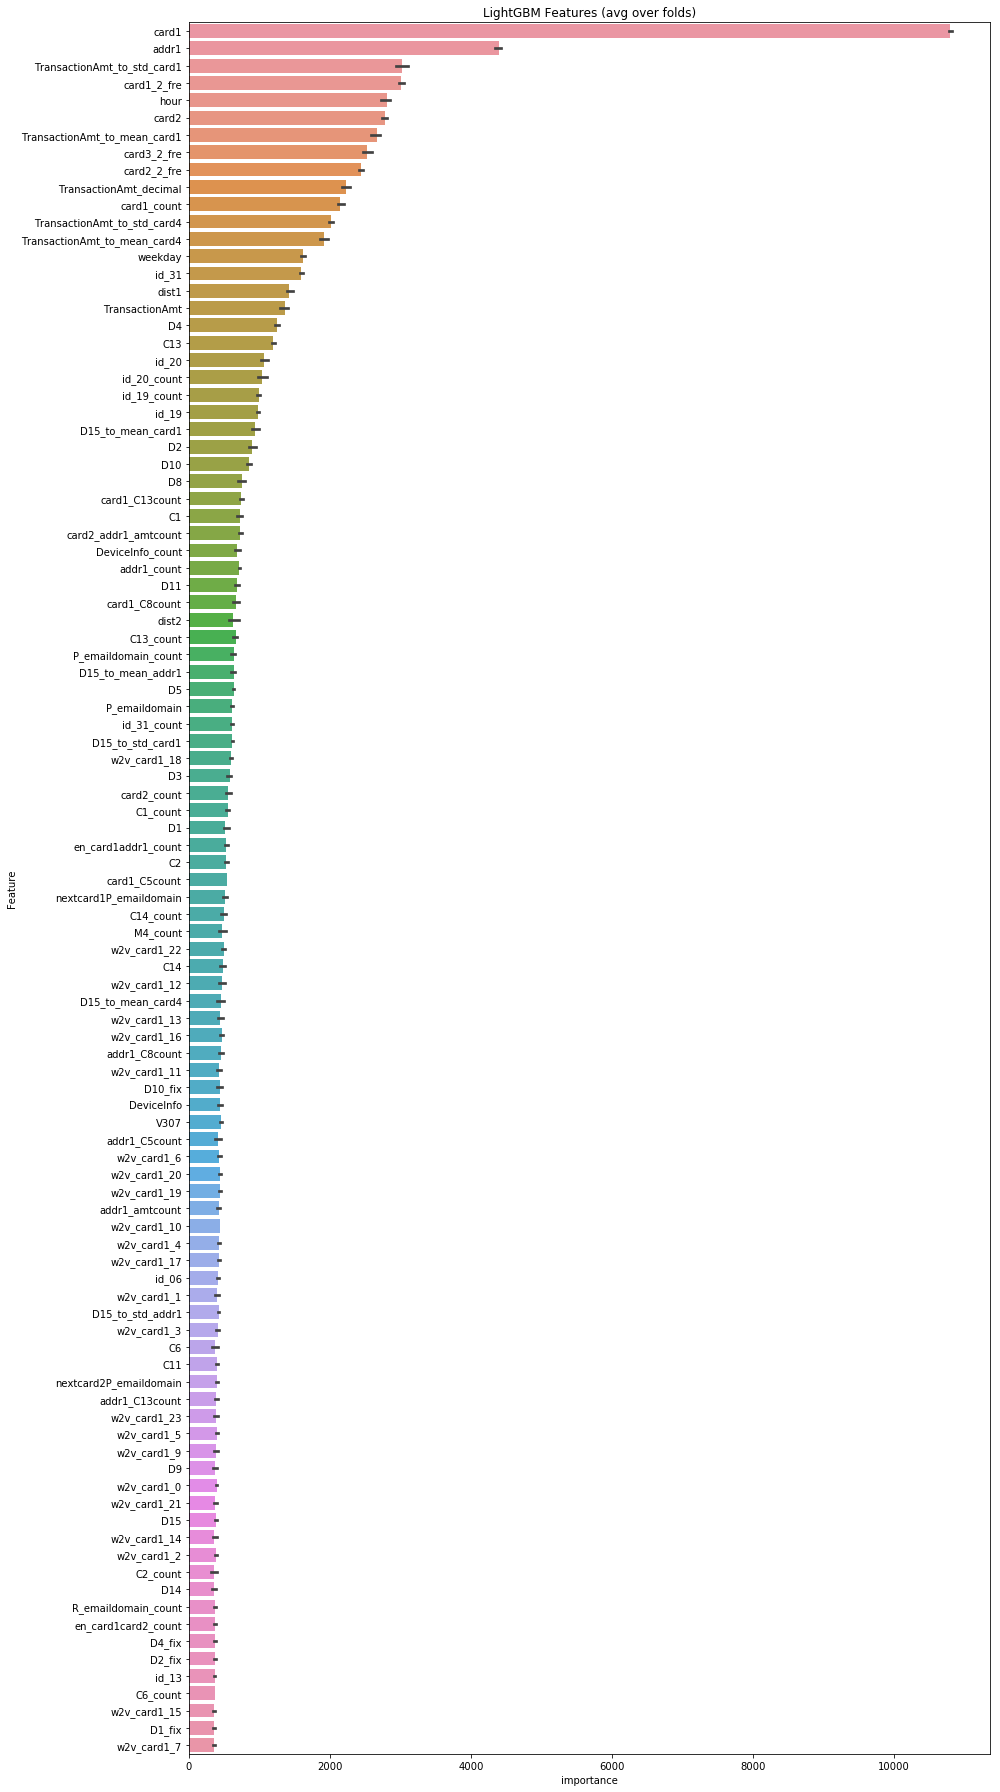

In [143]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[-100:].index)
print(cols)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [144]:
import catboost as cb
from catboost import CatBoostClassifier,Pool

# os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

features = [x for x in X_train.columns if (x not in col_del ) and  not x.startswith("w2v")]
print(len(features))
cate = [x for x in features if (x == 'ProductCD' or x in ['card1','card2'] or  x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" 
       and x not in train_f6.columns]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 700
y_preds3_temp = np.zeros(X_test.shape[0])
y_preds3_temp2 = np.zeros(X_test.shape[0])

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-999), X_train[features].iloc[val_idx, :].fillna(-999)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=15,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
                                ,min_data_in_leaf=15,l2_leaf_reg=3.0
                                ,task_type = "GPU",devices = ["1"]
                               )
    if debug:
#         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-999), y_test),verbose_eval = 30)
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    else:
#         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl[features], y_vl),verbose_eval = 30)
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    best_iter = model.get_best_iteration()
    best_iter = 0
    print(best_iter)
    y_pred_train = model.predict_proba(X_vl,ntree_end = best_iter)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp =  model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] 
    y_preds3 += temp/ folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))
        best_iter = num_rounds - 100
        y_preds3_temp += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
        best_iter = num_rounds - 200
        y_preds3_temp2 += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33))

506
['ProductCD', 'card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6136401	total: 1.33s	remaining: 15m 30s
30:	learn: 0.0874361	total: 39.7s	remaining: 14m 17s
60:	learn: 0.0632965	total: 1m 18s	remaining: 13m 47s
90:	learn: 0.0533863	total: 1m 58s	remaining: 13m 14s
120:	learn: 0.0482919	total: 2m 38s	remaining: 12m 37s
150:	learn: 0.0448464	total: 3m 17s	remaining: 11m 57s
180:	learn: 0.0423872	total: 3m 56s	remaining: 11m 16s
210:	learn: 0.0402975	total: 4m 34s	remaining: 10m 36s
240:	learn: 0.0385634	total: 5m 13s	remaining: 9m 56s
270:	learn: 0.0372277	total: 5m 51s	remaining: 9m 16s
300:	learn: 0.0360145	total: 6m 30s	remaining: 8m 37s
330:	learn: 0.0347097	total: 7m 8s	remaining: 7m 57s
360:	learn: 0.0333632	total: 7m 47s	remaining: 7m 18s
390:	learn: 0.0320185	total: 8m 25s	remaining: 6m 39s
420:	learn: 0.0308927	total: 9m 4s	remaining: 6m
450:	learn: 0.0298156	total

In [145]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0))


debug: 0.9375854577177285 0.08486393698049027
debug: 0.9241401996694465 0.09853189747461877
debug: 0.9254903399109391 0.09104222426596846
debug: 0.937697184392431 0.08357577106226544
debug: 0.9388402605245328 0.08332681164997997
debug: 0.940862612047512 0.08121211391431674
debug: 0.9409411384285441 0.08252996523574974


In [146]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*1.5 + y_preds*1.5 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*1.4 + y_preds*1.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/5))
    

debug: 0.9375854577177285 0.08486393698049027
debug: 0.9241401996694465 0.09853189747461877
debug: 0.9254903399109391 0.09104222426596846
debug: 0.937697184392431 0.08357577106226544
debug: 0.9388402605245328 0.08332681164997997
debug: 0.940862612047512 0.08529441472293203
debug: 0.9411297721945696 0.08066017672611524


In [147]:
if debug:
    X_test_pred = pd.DataFrame(index = X_test.index)
    X_test_pred['y_pred'] = y_preds
    X_test_pred['y_pred11'] = y_preds11
    X_test_pred['y_preds2'] = y_preds2
    X_test_pred['y_preds22'] = y_preds22
    X_test_pred['y_preds3'] = y_preds3
    X_test_pred['true'] = y_test
    X_test_pred.to_csv('simple_offline15.csv')
else:
    sample_submission['isFraud'] =  (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)/2.5
    sample_submission['isFraud'] =  (y_preds11*1.5 + y_preds*1.5 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/5
    sample_submission.to_csv('simple_ensemble15.csv')
